In [1]:
!pip install -q --no-index $(find /kaggle/input/sennet-wheels -name '*.whl')
!pip install -q --no-index --find-links=/kaggle/input/angionet-snapshot/snapshot angionet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.33.12 which is incompatible.


In [2]:
from pathlib import Path

import albumentations as A
import albumentations.pytorch as AP
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm

from angionet.core import predict
from angionet.datasets import InferenceDataset
from angionet.functional import combine_patches, decode, encode, extract_patches
from angionet.postprocessing import postprocess

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class config:
    root = "/kaggle/input/blood-vessel-segmentation"
    model = list(Path("/kaggle/input/angionet-snapshot").glob("*.pt"))[0]
    dim = 800
    stride = 600
    padding = 'reflect'
    lomc = True
    batch_size = 4
    thresholds = (0.2, 0.5)
    transforms = A.Compose([
        AP.ToTensorV2(),
     ])
    
    submission = True
    
# Disable scientific notation
np.set_printoptions(suppress=True)

In [4]:
if config.submission:
    paths = Path(config.root).glob("test/**/*.tif")
else:
    paths = Path(config.root).glob("train/kidney_2/images/*.tif")
    
data = []
for path in paths:
    id_ = path.parent.parent.name + "_" + path.stem
    data.append((id_, str(path)))
    
df = pd.DataFrame(data, columns = ['id', 'path'])
df['group'] = df['id'].apply(lambda x: "_".join(x.split("_")[:-1]))
df['image_id'] = df['id'].apply(lambda x: x.split('_')[-1])
df = df.sort_values(['group', 'image_id'])

if not config.submission:
    rles = pd.read_csv('/kaggle/input/blood-vessel-segmentation/train_rles.csv')
    df = df.merge(rles, on = 'id', how = 'left')

df.head()

,id,path,group,image_id
2,kidney_5_0000,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5,0000
0,kidney_5_0001,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5,0001
1,kidney_5_0002,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5,0002
5,kidney_6_0000,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6,0000
3,kidney_6_0001,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6,0001


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(config.model, map_location = device)

if config.submission:
    frame = df.copy()
else:
    frame = df.sample(100)

rles = []
for group, data in frame.groupby('group'):
    paths = data.path.values
    output = predict(model, paths, device, config)
    output = postprocess(output, threshold = 16, connectivity = 26)
    for out in output:
        rles.append(encode(out))

Processing: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


In [6]:
def visualize(paths, encodings, N=8, nrow = 4, figsize = (16, 8)):
    color = np.array([255, 10, 60], dtype="uint8")
    indices = np.random.permutation(np.arange(len(paths)))[:N]
    output = []
    for path, rle in zip(paths[indices], encodings[indices]):
        img = cv2.imread(path)
        mask = decode(rle, img.shape[:2])

        img = cv2.resize(img, (512, 512))
        mask = cv2.resize(mask, (512, 512))

        masked_img = np.where(mask[..., None], color, img)
        out = cv2.addWeighted(img, 0.8, masked_img, 0.2, 0)
        output.append(torch.from_numpy(out).permute(2, 0, 1))

    grid = make_grid(output, nrow=nrow).permute(1, 2, 0)
    fig = plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

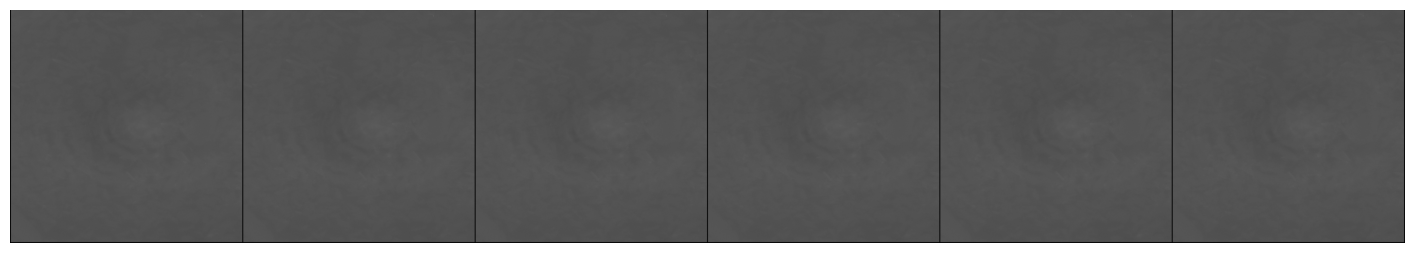

In [7]:
visualize(frame.path.values, np.array(rles), nrow = 6, figsize = (18, 8))

In [8]:
# if not config.submission:
#     from angionet.metrics import dice, confusion_matrix
    
#     labels, masks = [], []

#     for index, encoding in enumerate(output):
#         img = cv2.imread(frame.path.values[index], cv2.IMREAD_GRAYSCALE)

#         masks.append(decode(encoding, img.shape))
#         labels.append(decode(frame.rle.values[index], img.shape))

#     masks = np.asarray(np.stack(masks) / 255, dtype = np.uint8)
#     labels = np.asarray(np.stack(labels) / 255, dtype = np.uint8)
    
#     print(
#         dice(masks, labels),
#         confusion_matrix(masks, labels),
#         sep = '\n'
#     )

In [9]:
submission = pd.DataFrame({
    "id": frame.id.values,
    "rle": rles
})

submission

,id,rle
0,kidney_5_0000,1 0
1,kidney_5_0001,1 0
2,kidney_5_0002,1 0
3,kidney_6_0000,1 0
4,kidney_6_0001,1 0
5,kidney_6_0002,1 0


In [10]:
submission.to_csv("submission.csv", index = False)